In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Input, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import f1_score
from keras.regularizers import l2
np.random.seed(7)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MAX_SEQUENCE_LENGTH = 20
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 300

In [3]:
data = pd.read_csv("bitcoin_data.csv")

In [4]:
data.head()

,Timestamp,Username,Label,Tweet,URL
0,"March 14, 2018 at 09:47PM",@RizkyF_404,spam,RT @kickcity_io: Token Kart added KickCity to ...,http://twitter.com/RizkyF_404/status/973903509...
1,"March 14, 2018 at 09:47PM",@exchangebutler,spam,RT @Denaro_io: Our support team is here to hel...,http://twitter.com/exchangebutler/status/97390...
2,"March 14, 2018 at 09:47PM",@Bilalbinsaqib,pos,$eth trendline broke\nnext support @600 and th...,http://twitter.com/Bilalbinsaqib/status/973903...
3,"March 14, 2018 at 09:47PM",@ahsen_soydan,spam,RT @ahsen_soydanvip: 💎 High Quality Partner ✔️...,http://twitter.com/ahsen_soydan/status/9739035...
4,"March 14, 2018 at 09:47PM",@mourneopened,hype,RT @izx_io: IZETEX is on the Battle of the Cry...,http://twitter.com/mourneopened/status/9739035...


In [5]:
data = pd.DataFrame.dropna(data)
data = pd.DataFrame.drop_duplicates(data)

In [6]:
data = data[data.Label != 'neutral']

## Multi-class classification system with 5 classes

In [7]:
print(len(data.Label.unique()))
print(len(data))

5
1338


### Let's count

Label
doom     62
hype    177
neg      91
pos     211
spam    797
dtype: int64


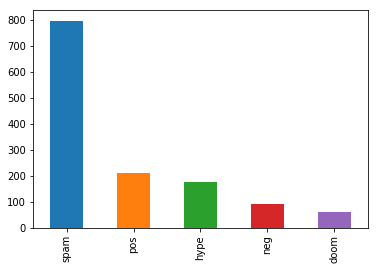

In [8]:
print(data.groupby('Label').size())
%matplotlib inline
import matplotlib as plt
data['Label'].value_counts().plot(kind="bar")

So first of all, this is really bad. Highly imbalanced classes. I read around 2500 tweets, from which I labeled only 1338 that seemed somewhat clear to me. This was the natural ratio. This huge amount of spam is obviously not good, but since we will set the volume of tweets as a separate feature we will keep this for now, just for the proof of concept. Put on TODO list: Get more data!!

In [9]:
texts = data["Tweet"].values
labels = data["Label"].values

## Cleaning tweets

In [10]:
# stemming + stopword_removal

import re
from nltk.corpus import stopwords

text = []
for i in range(0, len(texts)):
    tweet = re.sub('@([A-Za-z_]+)', ' ', texts[i]) # replace usernames with a whitespace
    tweet = re.sub('http([:/A-Za-z0-9_.]+)', ' ', tweet) # replace urls with a whitespace
    tweet = re.sub('https([:/A-Za-z0-9_.]+)', ' ', tweet) # replace urls with a whitespace
    tweet = re.sub('www([:/A-Za-z0-9_.]+)', ' ', tweet) # replace urls with a whitespace
    tweet = re.sub('[^a-zA-Z0-9.:_!?\-\(\)]', ' ', tweet) # replace everything that is not in the selection with a whitespac
    tweet = re.sub('(\s+)', ' ', tweet).lower().split() # replace multiple whitespaces with one whitespace, lowercase everything
    tweet = [word for word in tweet if not word in set(stopwords.words('english'))] # remove stopwords
    tweet = ' '.join(tweet)
    text.append(tweet)
    
text = np.asarray(text)


In [11]:
# tokenizing and sequencing

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 5148 unique tokens.


In [12]:
df = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
target_names = data.Label.unique() # list of label ids
target_dict = {n:i for i, n in enumerate(target_names)} # list of label names
labels = data.Label.map(target_dict)
labels = to_categorical(np.asarray(labels))

In [14]:
target_dict

{'doom': 4, 'hype': 2, 'neg': 3, 'pos': 1, 'spam': 0}

In [15]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1338, 5)
Shape of label tensor: (1338, 5)


### Looks good so far. Let's shuffle a bit and split our X and y in 0.8 train and 0.2 test.

In [16]:
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
data = df[indices]
labels = labels[indices]

In [17]:
X = data
y = labels

In [18]:
# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

## Pre-training on Glove embeddings

In [19]:
# embedding matrx
embeddings_index = {}
f = open('/Users/suzana/Downloads/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# embedding matrix
count = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
#embedding_matrix = np.random.uniform(size=(len(word_index) + 1, EMBEDDING_DIM),low=-0.1, high=0.1)
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros. other embedding matrix: low=-0.1, high=0.1
        embedding_matrix[index] = embedding_vector
    else:
        count += 1
print('Found %s unknown words.' % count) 


# embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) 

Found 400000 word vectors.
Found 1205 unknown words.


In [20]:
# build model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.3)))
model.add(Dropout(0.3))
model.add(Dense(len(target_names), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])

In [21]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=4, validation_data=(X_test, y_test))

Train on 1070 samples, validate on 268 samples
Epoch 1/4
1070/1070 [==============================] - 6s 5ms/step - loss: 1.1679 - acc: 0.5729 - val_loss: 1.0303 - val_acc: 0.6493
Epoch 2/4
1070/1070 [==============================] - 4s 3ms/step - loss: 0.9159 - acc: 0.6439 - val_loss: 1.0420 - val_acc: 0.6306
Epoch 3/4
1070/1070 [==============================] - 4s 3ms/step - loss: 0.7683 - acc: 0.7168 - val_loss: 1.0771 - val_acc: 0.6119
Epoch 4/4
1070/1070 [==============================] - 4s 4ms/step - loss: 0.6095 - acc: 0.7832 - val_loss: 1.0401 - val_acc: 0.6343


In [22]:
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class, digits=3))

             precision    recall  f1-score   support

          0      0.810     0.830     0.820       159
          1      0.323     0.467     0.382        45
          2      0.448     0.433     0.441        30
          3      0.400     0.125     0.190        16
          4      0.333     0.111     0.167        18

avg / total      0.631     0.634     0.622       268



In [23]:
print(target_dict)

{'spam': 0, 'pos': 1, 'hype': 2, 'neg': 3, 'doom': 4}


#### RECAP

Well, fair enough. That is as expected not a very satisfying result. Loss is unstable and the acc is much higher than val acc. We have a couple of things on our TODO list:
* Thorough cleaning (strip off all those urls, usernames and other useless stuff)
* Balance imbalanced classes
* This architecture works definitely better (+3.1%) than a gridsearched SVM, that I built earlier, however maybe the hyperparamters are not optimal
* Get more data! Especially the important categories: hype and doom. For sentiment we can always add a transferlearning arlgorithm that learns representations from a much larger traditional sentiment corpus